In [16]:
# Section 4: ResNet (skip) vs Plain + Transfer Learning + Augmentations
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm

import medmnist
from medmnist import INFO

torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [17]:
# Medical dataset: PneumoniaMNIST (binary classification: normal vs pneumonia)
DATASET_NAME = "pneumoniamnist"
info = INFO[DATASET_NAME]
DataClass = getattr(medmnist, info["python_class"])

print("Task:", info["task"])
print("n_channels:", info["n_channels"])
print("label mapping:", info["label"])   # {0:..., 1:...}


Task: binary-class
n_channels: 1
label mapping: {'0': 'normal', '1': 'pneumonia'}


In [18]:
# Two pipelines:
# 1) No augmentation (baseline)
# 2) With augmentation (>=5 techniques) to improve generalization

to_tensor = transforms.Compose([transforms.ToTensor()])

train_tf_noaug = transforms.Compose([
    transforms.ToTensor(),
])

train_tf_aug = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.85, 1.0)),   # (1) crop/scale
    transforms.RandomRotation(15),                         # (2) rotation
    transforms.RandomAffine(0, translate=(0.1, 0.1)),       # (3) translation
    transforms.RandomHorizontalFlip(p=0.5),                 # (4) flip
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),# (5) blur
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # (6) intensity jitter
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
])


In [19]:
# Load official splits (train/val/test)
train_ds = DataClass(split="train", transform=train_tf_noaug, download=True)
val_ds   = DataClass(split="val",   transform=test_tf,       download=True)
test_ds  = DataClass(split="test",  transform=test_tf,       download=True)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

x0, y0 = next(iter(train_loader))
print("x:", x0.shape, x0.dtype, "y:", y0.shape, y0.dtype)  # y usually (B,1) in MedMNIST


100%|██████████| 4.17M/4.17M [00:04<00:00, 842kB/s] 


Using downloaded and verified file: C:\Users\Zhanel\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Zhanel\.medmnist\pneumoniamnist.npz
x: torch.Size([128, 1, 28, 28]) torch.float32 y: torch.Size([128, 1]) torch.int32


In [21]:
def adapt_to_3ch(x):
    # ResNet pretrained expects 3 channels; PneumoniaMNIST is grayscale (1 channel)
    if x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    return x

@torch.no_grad()
def evaluate(model, loader):
    # Binary classification metrics: loss + accuracy
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x = adapt_to_3ch(x.to(device).float())
        y = y.to(device).long().view(-1)  # (B,)

        logits = model(x)                 # (B, 2)
        loss = F.cross_entropy(logits, y)

        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
        total_loss += loss.item() * x.size(0)

    return total_loss / total, correct / total


In [22]:
# 4.1 ResNet blocks vs Plain net + Gradient flow
# ResNet-style block with skip connection
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        # Projection shortcut if shape changes
        self.shortcut = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)   # skip connection
        return F.relu(out)

# Plain block: same depth, no skip
class PlainBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class SmallNet(nn.Module):
    # Same macro-architecture, switch block type to compare skip vs no-skip
    def __init__(self, block_cls, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = block_cls(32, 32, stride=1)
        self.layer2 = block_cls(32, 64, stride=2)
        self.layer3 = block_cls(64, 128, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

plain_model = SmallNet(PlainBlock, num_classes=2).to(device)
skip_model  = SmallNet(BasicBlock, num_classes=2).to(device)


In [23]:
def grad_mean_norm(model):
    # Mean L2 norm of gradients across parameters (simple gradient flow indicator)
    norms = []
    for p in model.parameters():
        if p.grad is not None:
            norms.append(p.grad.data.norm(2).item())
    return float(np.mean(norms)) if norms else 0.0

def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[], "grad_mean":[]}

    for ep in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        grad_means = []

        for x, y in tqdm(train_loader, leave=False):
            x = adapt_to_3ch(x.to(device).float())
            y = y.to(device).long().view(-1)     # (B,)

            opt.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()

            grad_means.append(grad_mean_norm(model))
            opt.step()

            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        train_loss = total_loss / total
        train_acc  = correct / total
        test_loss, test_acc = evaluate(model, test_loader)

        hist["train_loss"].append(train_loss)
        hist["train_acc"].append(train_acc)
        hist["test_loss"].append(test_loss)
        hist["test_acc"].append(test_acc)
        hist["grad_mean"].append(float(np.mean(grad_means)))

        print(f"Epoch {ep:02d} | train acc {train_acc:.4f} | test acc {test_acc:.4f} | grad_mean {hist['grad_mean'][-1]:.3e}")

    return hist

hist_plain = train_model(plain_model, train_loader, test_loader, epochs=5, lr=1e-3)
hist_skip  = train_model(skip_model,  train_loader, test_loader, epochs=5, lr=1e-3)


Epoch 01 | train acc 0.9163 | test acc 0.6250 | grad_mean 1.557e-01


Epoch 02 | train acc 0.9579 | test acc 0.6122 | grad_mean 9.863e-02


Epoch 03 | train acc 0.9637 | test acc 0.8846 | grad_mean 1.224e-01


Epoch 04 | train acc 0.9718 | test acc 0.8510 | grad_mean 8.758e-02


Epoch 05 | train acc 0.9747 | test acc 0.7804 | grad_mean 1.082e-01


Epoch 01 | train acc 0.9218 | test acc 0.6250 | grad_mean 1.338e-01


Epoch 02 | train acc 0.9567 | test acc 0.8846 | grad_mean 8.472e-02


Epoch 03 | train acc 0.9660 | test acc 0.7997 | grad_mean 9.309e-02


Epoch 04 | train acc 0.9747 | test acc 0.7644 | grad_mean 8.165e-02


Epoch 05 | train acc 0.9754 | test acc 0.8878 | grad_mean 9.337e-02


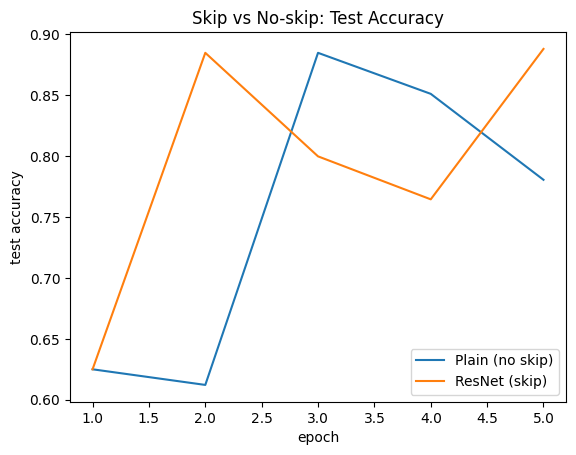

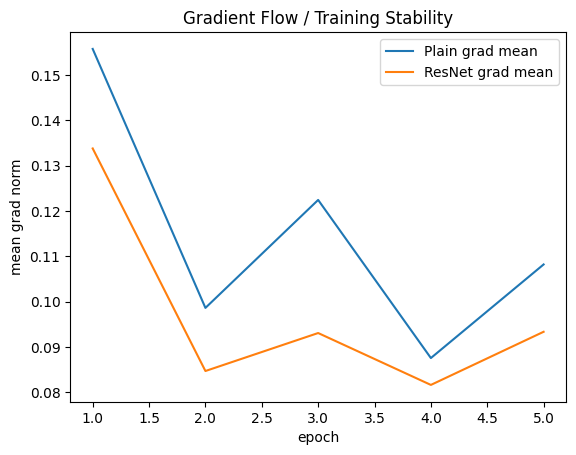

In [24]:
def plot_hist(h_plain, h_skip):
    xs = np.arange(1, len(h_plain["test_acc"]) + 1)

    plt.figure()
    plt.plot(xs, h_plain["test_acc"], label="Plain (no skip)")
    plt.plot(xs, h_skip["test_acc"],  label="ResNet (skip)")
    plt.xlabel("epoch"); plt.ylabel("test accuracy"); plt.title("Skip vs No-skip: Test Accuracy")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(xs, h_plain["grad_mean"], label="Plain grad mean")
    plt.plot(xs, h_skip["grad_mean"],  label="ResNet grad mean")
    plt.xlabel("epoch"); plt.ylabel("mean grad norm"); plt.title("Gradient Flow / Training Stability")
    plt.legend(); plt.show()

plot_hist(hist_plain, hist_skip)


In [25]:
# 4.2 Transfer learning: pretrained vs from scratch
# Torchvision ResNet18 supports pretrained ImageNet weights via weights=ResNet18_Weights.DEFAULT. :contentReference[oaicite:2]{index=2}
from torchvision.models import ResNet18_Weights

def make_resnet18(num_classes=2, pretrained=True):
    if pretrained:
        m = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

model_pretrained = make_resnet18(2, pretrained=True)
model_scratch    = make_resnet18(2, pretrained=False)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Zhanel/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:31<00:00, 1.48MB/s]


In [26]:
def set_finetune(model, mode="linear"):
    # mode="linear": train only the final layer
    # mode="full": train all layers
    for p in model.parameters():
        p.requires_grad = True
    if mode == "linear":
        for name, p in model.named_parameters():
            if not name.startswith("fc."):
                p.requires_grad = False

def train_tl(model, train_loader, test_loader, epochs=3, lr=1e-3, mode="linear"):
    set_finetune(model, mode)
    params = [p for p in model.parameters() if p.requires_grad]
    opt = torch.optim.Adam(params, lr=lr)

    hist = {"train_acc":[], "test_acc":[], "train_loss":[], "test_loss":[]}

    for ep in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for x, y in tqdm(train_loader, leave=False):
            x = adapt_to_3ch(x.to(device).float())
            y = y.to(device).long().view(-1)

            opt.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

        tr_loss = total_loss/total
        tr_acc  = correct/total
        te_loss, te_acc = evaluate(model, test_loader)

        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["test_loss"].append(te_loss)
        hist["test_acc"].append(te_acc)

        print(f"Epoch {ep:02d} | train acc {tr_acc:.4f} | test acc {te_acc:.4f}")

    return hist

hist_tl_pre = train_tl(model_pretrained, train_loader, test_loader, epochs=3, lr=1e-3, mode="linear")
hist_tl_scr = train_tl(model_scratch,    train_loader, test_loader, epochs=3, lr=1e-3, mode="linear")


Epoch 01 | train acc 0.7965 | test acc 0.6571


Epoch 02 | train acc 0.8626 | test acc 0.7356


Epoch 03 | train acc 0.8766 | test acc 0.7452


Epoch 01 | train acc 0.8014 | test acc 0.5288


Epoch 02 | train acc 0.8738 | test acc 0.7596


Epoch 03 | train acc 0.8900 | test acc 0.7901


In [27]:
# 4.3 Augmentation impact (≥5 augs + generalization)
# Reload train dataset with augmentation
train_ds_aug = DataClass(split="train", transform=train_tf_aug, download=True)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True, num_workers=0)

model_pre_noaug = make_resnet18(2, pretrained=True)
model_pre_aug   = make_resnet18(2, pretrained=True)

hist_noaug = train_tl(model_pre_noaug, train_loader,     test_loader, epochs=3, lr=1e-3, mode="linear")
hist_aug   = train_tl(model_pre_aug,   train_loader_aug, test_loader, epochs=3, lr=1e-3, mode="linear")

print("Final test acc (pretrained, no aug):", hist_noaug["test_acc"][-1])
print("Final test acc (pretrained, aug):   ", hist_aug["test_acc"][-1])


Using downloaded and verified file: C:\Users\Zhanel\.medmnist\pneumoniamnist.npz


Epoch 01 | train acc 0.7655 | test acc 0.6522


Epoch 02 | train acc 0.8596 | test acc 0.7131


Epoch 03 | train acc 0.8734 | test acc 0.7596


Epoch 01 | train acc 0.7513 | test acc 0.6651


Epoch 02 | train acc 0.8067 | test acc 0.7484


Epoch 03 | train acc 0.8080 | test acc 0.7837
Final test acc (pretrained, no aug): 0.7596153846153846
Final test acc (pretrained, aug):    0.7836538461538461


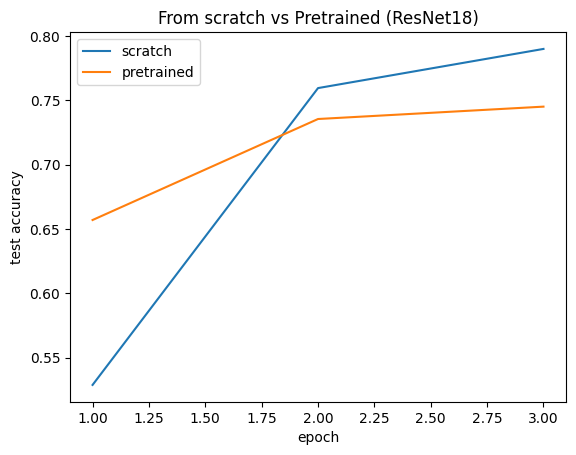

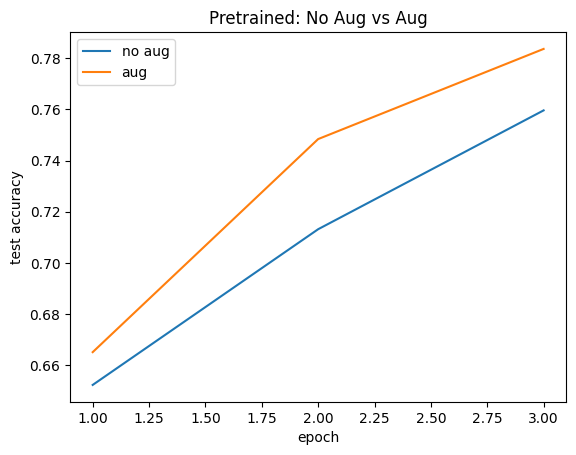

In [28]:
def plot_compare(a, b, title, name_a, name_b):
    xs = np.arange(1, len(a["test_acc"]) + 1)
    plt.figure()
    plt.plot(xs, a["test_acc"], label=name_a)
    plt.plot(xs, b["test_acc"], label=name_b)
    plt.xlabel("epoch"); plt.ylabel("test accuracy"); plt.title(title)
    plt.legend(); plt.show()

plot_compare(hist_tl_scr, hist_tl_pre, "From scratch vs Pretrained (ResNet18)", "scratch", "pretrained")
plot_compare(hist_noaug,  hist_aug,    "Pretrained: No Aug vs Aug",            "no aug", "aug")
